In [1]:
import scanpy as sc
import pandas as pd
import harmony
print(harmony.__version__)  # 确认版本
import scanpy.external as scx


0.1.8


In [2]:
#载入数据
adata = sc.read_h5ad("/home/cluster2/tangzefang/yangbo/01_data/mouse_gut_normal_62k.h5ad")
#检查数据
print(adata)
print(adata.obs.columns.tolist()) #细胞样本信息表，来自的组织疾病等
print(adata.var.columns.tolist()) #基因说明书，基因名字id等

AnnData object with n_obs × n_vars = 62121 × 53850
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'batch'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_type', 'feature_length', 'nnz', 'n_measured_obs'
['soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'sel

In [3]:
print("1. 原始数据levels情况:")
print(f"   原始levels数量: {len(adata.obs['cell_type'].cat.categories)}")
print(f"   原始细胞类型示例:")
for i, category in enumerate(adata.obs['cell_type'].cat.categories[:10]):
    print(f"     {i+1}. {category}")

1. 原始数据levels情况:
   原始levels数量: 448
   原始细胞类型示例:
     1. B cell
     2. B cell zone reticular cell
     3. Bergmann glial cell
     4. CD103-positive dendritic cell
     5. CD141-positive myeloid dendritic cell
     6. CD1c-positive myeloid dendritic cell
     7. CD4-positive, alpha-beta T cell
     8. CD4-positive, alpha-beta memory T cell
     9. CD4-positive, alpha-beta thymocyte
     10. CD8-positive, alpha-beta T cell


清理前levels数量: 448
清理后levels数量: 45


/home/cluster2/tangzefang/yangbo/miniconda3/envs/jupyter/lib/python3.10/site-packages/scanpy/neighbors/__init__.py:586: UserWarning: You’re trying to run this on 53850 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  X = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


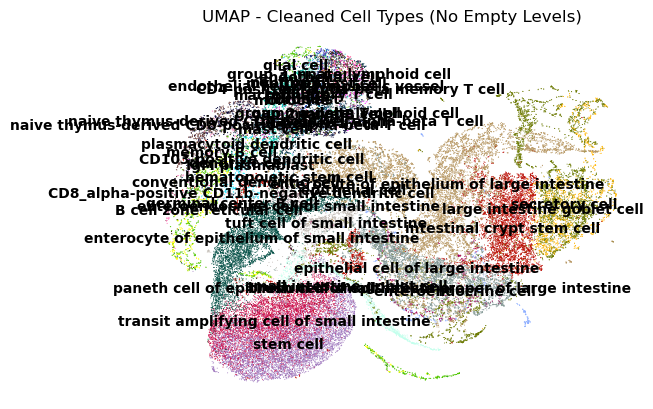

<Figure size 640x480 with 0 Axes>

In [4]:
#方法1：先清理levels，再计算UMAP（推荐）
# -------------------------------
# 1. 复制数据并清理levels
import matplotlib.pyplot as plt
adata_clean = adata.copy()
adata_clean.obs['cell_type'] = adata_clean.obs['cell_type'].astype(str).astype('category')

print(f"清理前levels数量: {len(adata.obs['cell_type'].cat.categories)}")
print(f"清理后levels数量: {len(adata_clean.obs['cell_type'].cat.categories)}")

# 2. 计算UMAP（使用清理后的数据）
sc.pp.neighbors(adata_clean, n_neighbors=15, n_pcs=25)
sc.tl.umap(adata_clean)

# 3. 绘制UMAP（现在图例只显示实际存在的细胞类型）
sc.pl.umap(adata_clean, color=['cell_type'], 
           title='UMAP - Cleaned Cell Types (No Empty Levels)',
           frameon=False, legend_loc='on data')
plt.savefig('umap_cleaned_levels.png', dpi=300, bbox_inches='tight')
plt.show()


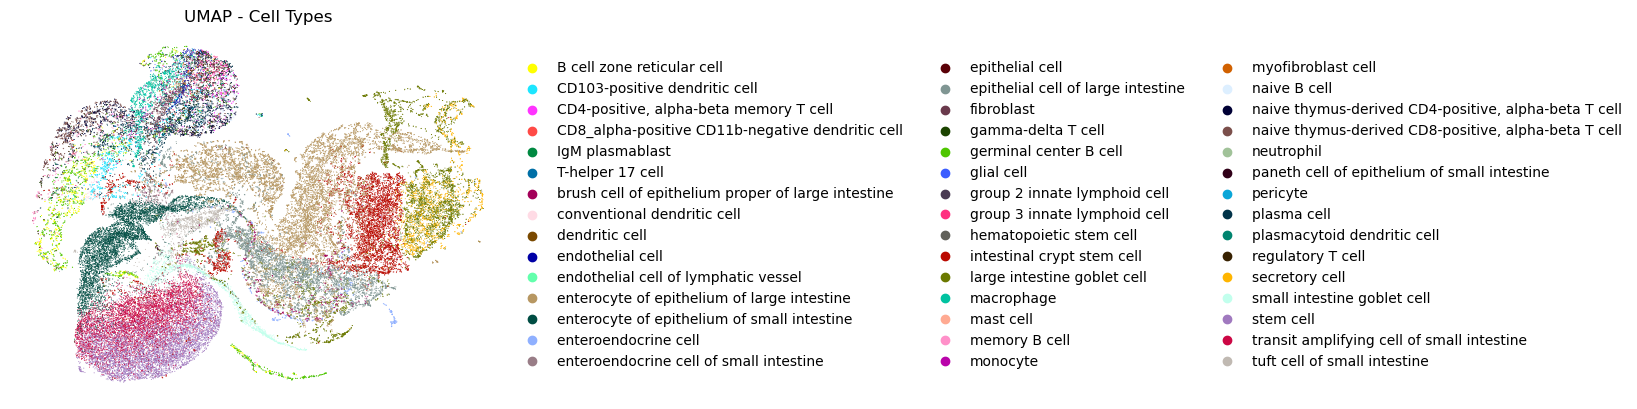

<Figure size 640x480 with 0 Axes>

In [5]:
#图例更改
sc.pl.umap(adata_clean, color=['cell_type'], 
           title='UMAP - Cell Types',
           frameon=False,
           legend_loc='right margin')  # 在右侧显示图例
plt.savefig('umap_right_legend.png', dpi=300, bbox_inches='tight')
plt.show()

     n_genes_by_counts  total_counts  mt_counts  pct_counts_mt
0-0               1301        3640.0       39.0       1.071429
1-0               1753        5173.0       66.0       1.275855
2-0               1169        2135.0       35.0       1.639344
3-0                861        1786.0       26.0       1.455767
4-0               1142        3422.0       33.0       0.964348

线粒体比例统计:
count    62121.000000
mean         2.361463
std          3.996435
min          0.000000
25%          0.000000
50%          0.012252
75%          4.741897
max         37.213783
Name: pct_counts_mt, dtype: float64

筛选前细胞数: 62121
筛选后细胞数: 36057
过滤掉的细胞数: 26064
保留比例: 58.0%

筛选后n_genes_by_counts统计:
count    36057.000000
mean      2534.950523
std       1091.684039
min        500.000000
25%       1501.000000
50%       2650.000000
75%       3477.000000
max       5240.000000
Name: n_genes_by_counts, dtype: float64

筛选后total_counts统计:
count    36057.000000
mean     10300.966797
std       5028.522461
min       1002.00

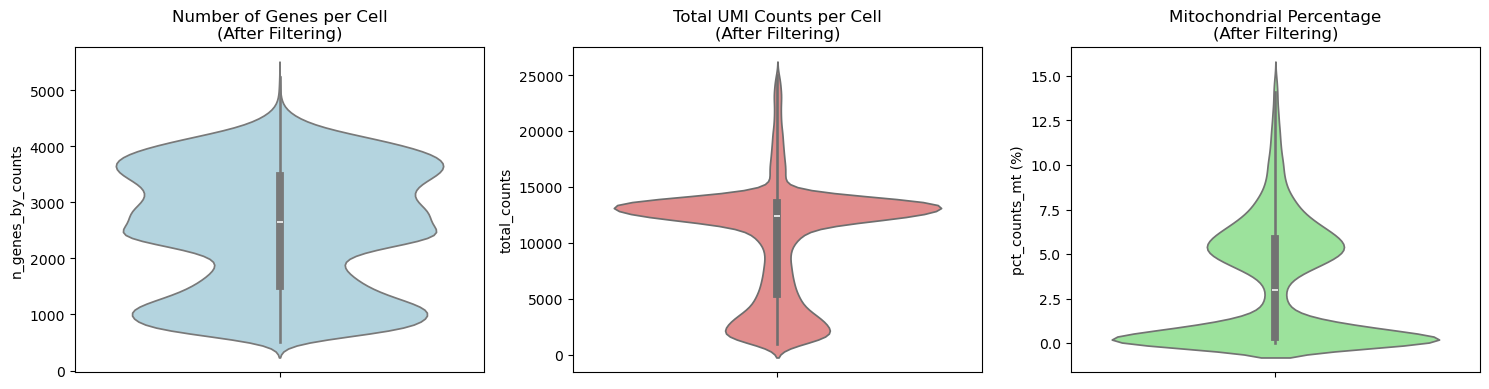

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 计算线粒体比例
# -------------------------------
mt_gene_mask = adata_clean.var["feature_name"].str.lower().str.startswith("mt-")
adata_clean.obs["mt_counts"] = adata_clean[:, mt_gene_mask].X.sum(axis=1).A1
adata_clean.obs["total_counts"] = adata_clean.X.sum(axis=1).A1
adata_clean.obs["pct_counts_mt"] = adata_clean.obs["mt_counts"] / adata_clean.obs["total_counts"] * 100
adata_clean.obs["n_genes_by_counts"] = (adata_clean.X > 0).sum(axis=1).A1

print(adata_clean.obs[["n_genes_by_counts", "total_counts", "mt_counts", "pct_counts_mt"]].head())

# 查看线粒体比例统计
print("\n线粒体比例统计:")
print(adata_clean.obs["pct_counts_mt"].describe())

# 直接使用你的计算结果进行筛选
# -------------------------------
min_genes = 500
max_genes = 6000
min_counts = 1000
max_counts = 25000
max_mt = 15  # 百分比

# 筛选前的细胞数
print(f"\n筛选前细胞数: {adata_clean.n_obs}")

# 应用筛选条件 - 使用你自己计算的pct_counts_mt
adata_qc = adata_clean[
    (adata_clean.obs["n_genes_by_counts"] >= min_genes) &
    (adata_clean.obs["n_genes_by_counts"] <= max_genes) &
    (adata_clean.obs["total_counts"] >= min_counts) &
    (adata_clean.obs["total_counts"] <= max_counts) &
    (adata_clean.obs["pct_counts_mt"] <= max_mt)
].copy()

print(f"筛选后细胞数: {adata_qc.n_obs}")
print(f"过滤掉的细胞数: {adata.n_obs - adata_qc.n_obs}")
print(f"保留比例: {adata_qc.n_obs/adata.n_obs*100:.1f}%")

# 查看筛选后的统计信息
print("\n筛选后n_genes_by_counts统计:")
print(adata_qc.obs["n_genes_by_counts"].describe())

print("\n筛选后total_counts统计:")
print(adata_qc.obs["total_counts"].describe())

# 绘制筛选后的QC图
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.violinplot(y=adata_qc.obs['n_genes_by_counts'], color='lightblue')
plt.title('Number of Genes per Cell\n(After Filtering)')
plt.ylabel('n_genes_by_counts')

plt.subplot(1, 3, 2)
sns.violinplot(y=adata_qc.obs['total_counts'], color='lightcoral')
plt.title('Total UMI Counts per Cell\n(After Filtering)')
plt.ylabel('total_counts')

plt.subplot(1, 3, 3)
sns.violinplot(y=adata_qc.obs['pct_counts_mt'], color='lightgreen')
plt.title('Mitochondrial Percentage\n(After Filtering)')
plt.ylabel('pct_counts_mt (%)')

plt.tight_layout()
plt.savefig('qc_after_filtering.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
# 运行PCA，保留50个主成分
sc.tl.pca(adata_qc, n_comps=50, svd_solver="arpack")

# 确认PCA结果已经存储
print(adata_qc.obsm.keys())  # 这应该输出 'X_pca'


KeysView(AxisArrays with keys: X_pca, X_umap)


In [8]:
# 使用Harmony去除批次效应
scx.pp.harmony_integrate(adata_qc, key='batch')  # 'batch' 是批次信息的列名

# 或者使用ComBat去除批次效应（如果需要）
# sc.pp.combat(adata_qc, key='batch')


2025-10-22 17:14:49,297 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-10-22 17:14:53,440 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-10-22 17:14:53,584 - harmonypy - INFO - Iteration 1 of 10
2025-10-22 17:15:06,572 - harmonypy - INFO - Iteration 2 of 10
2025-10-22 17:15:19,109 - harmonypy - INFO - Iteration 3 of 10
2025-10-22 17:15:31,848 - harmonypy - INFO - Iteration 4 of 10
2025-10-22 17:15:44,383 - harmonypy - INFO - Iteration 5 of 10
2025-10-22 17:15:56,867 - harmonypy - INFO - Iteration 6 of 10
2025-10-22 17:16:09,467 - harmonypy - INFO - Iteration 7 of 10
2025-10-22 17:16:21,941 - harmonypy - INFO - Converged after 7 iterations


/home/cluster2/tangzefang/yangbo/miniconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


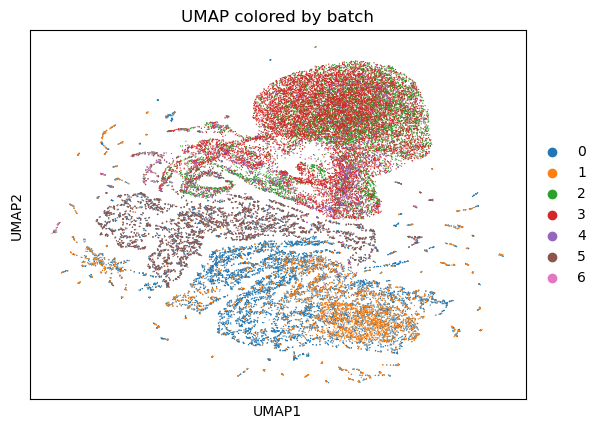

In [9]:
#看一下不同批次的细胞都重合度，然后用harmony和combat去除批次效应
# 使用UMAP进行降维可视化
sc.pp.neighbors(adata_qc, n_neighbors=15, n_pcs=50)  # 使用前50个主成分
sc.tl.umap(adata_qc)

# 查看UMAP图，按批次着色
sc.pl.umap(adata_qc, color='batch', title="UMAP colored by batch")

In [14]:
# 查看每个批次的细胞总数
print("每个批次的细胞数量:")
print(adata.obs['batch'].value_counts().sort_index())

# 查看每个批次中细胞类型的分布情况
print("\n每个批次的细胞类型分布:")
for batch in sorted(adata.obs['batch'].unique()):
    batch_data = adata.obs[adata.obs['batch'] == batch]
    print(f"\n批次 {batch}:")
    print(f"  细胞总数: {len(batch_data)}")
    print(f"  细胞类型数量: {batch_data['cell_type'].nunique()}")
    print(f"  主要细胞类型:")
    print(batch_data['cell_type'].value_counts().head(10))

每个批次的细胞数量:
batch
0    10000
1    10000
2    10000
3    10000
4    10000
5    10000
6     2121
Name: count, dtype: int64

每个批次的细胞类型分布:

批次 0:
  细胞总数: 10000
  细胞类型数量: 34
  主要细胞类型:
cell_type
germinal center B cell                                  1339
enterocyte of epithelium of large intestine             1125
plasma cell                                              923
naive thymus-derived CD4-positive, alpha-beta T cell     885
naive thymus-derived CD8-positive, alpha-beta T cell     801
B cell zone reticular cell                               673
macrophage                                               579
regulatory T cell                                        479
CD103-positive dendritic cell                            428
intestinal crypt stem cell                               339
Name: count, dtype: int64

批次 1:
  细胞总数: 10000
  细胞类型数量: 37
  主要细胞类型:
cell_type
enterocyte of epithelium of large intestine    2015
epithelial cell of large intestine             1286
large intestine go

/home/cluster2/tangzefang/yangbo/miniconda3/envs/jupyter/lib/python3.10/site-packages/umap/umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


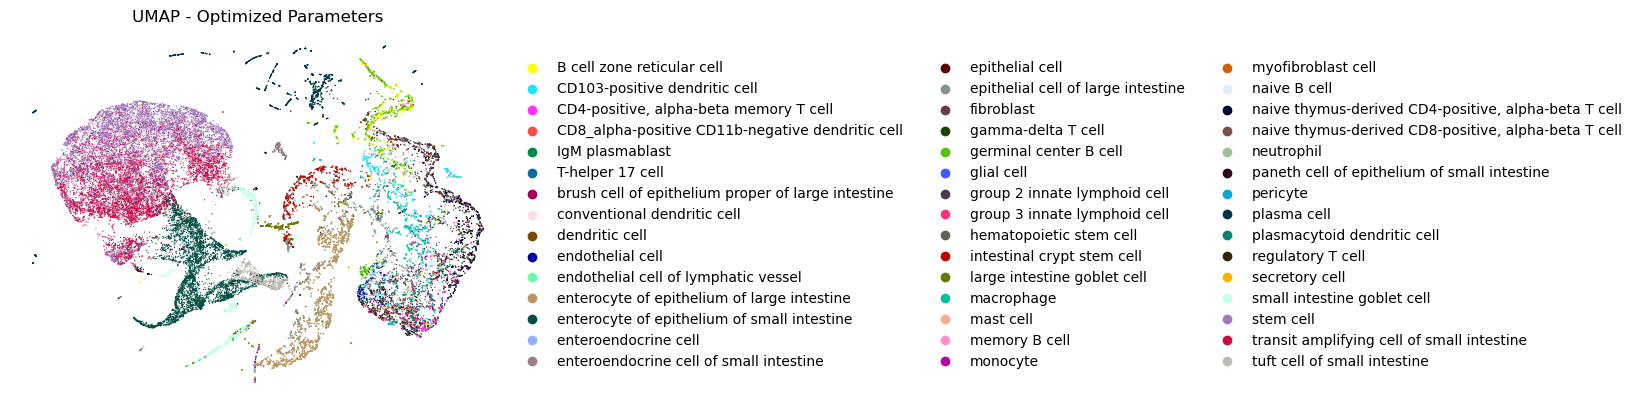

<Figure size 640x480 with 0 Axes>

KeyError: 'leiden_0.5'

In [10]:
sdata_inte = adata_qc.copy() 

n_PCs, umap_n_neighbors, umap_n_pcs, min_dist, spread_t = [50, 50, 30, 0.01, 5] 
pc_feature = 'X_pca'

sc.pp.neighbors(sdata_inte, n_neighbors=umap_n_neighbors, n_pcs=umap_n_pcs, use_rep=pc_feature)
sc.tl.umap(sdata_inte, min_dist=min_dist, spread=spread_t)  # 修正参数名

sc.pl.umap(sdata_inte, color=['cell_type'], 
           title='UMAP - Optimized Parameters',
           frameon=False, legend_loc='right margin') 
plt.savefig('umap_optimized.png', dpi=300, bbox_inches='tight')
plt.show()


# marker分析，查看每个聚类中显著基因
sc.tl.rank_genes_groups(adata_qc, groupby='leiden_0.5') 
sc.pl.rank_genes_groups(adata_qc, n_genes=20, sharey=False)

In [ ]:
import pandas as pd

# 1. 首先加载基因列表文件
neural_genes = pd.read_csv('Neural_genesymbol_list_mus_musculus.csv')
gene_pairs = pd.read_csv('NeuronChat_gene_pairs_mus_musculus.csv')
# 筛选神经相关基因
neural_genes_set = set(neural_genes['gene_symbol'])  # 转换为集合便于快速查找

# 从NeuronChat_gene_pairs中筛选神经相关的配体和受体
ligands = gene_pairs[(gene_pairs['gene_symbol'].isin(neural_genes_set)) & (gene_pairs['type'] == 'ligand')]
receptors = gene_pairs[(gene_pairs['gene_symbol'].isin(neural_genes_set)) & (gene_pairs['type'] == 'receptor')]

# 打印筛选后的配体和受体
print("\nFiltered ligands:")
print(ligands)

print("\nFiltered receptors:")
print(receptors)


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import sparse

# 1. 加载数据
neural_genes = pd.read_csv('Neural_genesymbol_list_mus_musculus.csv')
gene_pairs = pd.read_csv('NeuronChat_gene_pairs_mus_musculus.csv')

# 将neural_genes['gene_symbol']转换为集合，以便快速查找
neural_genes_set = set(neural_genes['gene_symbol'])

# 基于基因符号筛选配体和受体
ligands = gene_pairs[(gene_pairs['gene_symbol'].isin(neural_genes_set)) & (gene_pairs['type'] == 'ligand')]
receptors = gene_pairs[(gene_pairs['gene_symbol'].isin(neural_genes_set)) & (gene_pairs['type'] == 'receptor')]

print("筛选后的配体数量:", len(ligands))
print("筛选后的受体数量:", len(receptors))

# 2. 检查数据状态
print("\n=== 数据状态检查 ===")
print(f"adata_qc.raw is None: {adata_qc.raw is None}")
print(f"adata_qc.shape: {adata_qc.shape}")
print(f"adata_qc.var_names 数量: {len(adata_qc.var_names)}")

# 3. 使用主数据而不是raw数据
gene_names = adata_qc.var_names  # 使用主数据的基因名

In [20]:
# 创建基因符号到数字ID的映射
feature_name_to_id = dict(zip(adata_qc.var['feature_name'], adata_qc.var.index))

print(f"创建了 {len(feature_name_to_id)} 个基因的映射")
print("映射示例:", list(feature_name_to_id.items())[:5])

# 重新筛选可用的配体和受体
available_ligands = []
for gene in ligands['gene_symbol']:
    if gene in feature_name_to_id:
        available_ligands.append(feature_name_to_id[gene])  # 存储数字ID

available_receptors = []
for gene in receptors['gene_symbol']:
    if gene in feature_name_to_id:
        available_receptors.append(feature_name_to_id[gene])

print(f"\n=== 匹配结果 ===")
print(f"找到的配体: {len(available_ligands)}/{len(ligands)}")
print(f"找到的受体: {len(available_receptors)}/{len(receptors)}")

# 显示匹配的基因
if available_ligands:
    matched_ligands = [gene for gene in ligands['gene_symbol'] if gene in feature_name_to_id]
    print("\n匹配的配体示例:", matched_ligands[:10])
if available_receptors:
    matched_receptors = [gene for gene in receptors['gene_symbol'] if gene in feature_name_to_id]
    print("匹配的受体示例:", matched_receptors[:10])

创建了 53850 个基因的映射
映射示例: [('Vti1b', '0'), ('Hlx', '1'), ('Dhx58os', '2'), ('Gm16070', '3'), ('Sfswap', '4')]

=== 匹配结果 ===
找到的配体: 65/65
找到的受体: 154/154

匹配的配体示例: ['Vip', 'Npy', 'Sst', 'Penk', 'Tac2', 'Cck', 'Crh', 'Tac1', 'Pdyn', 'Cort']
匹配的受体示例: ['Vipr1', 'Vipr2', 'Npy1r', 'Npy2r', 'Npy5r', 'Sstr1', 'Sstr2', 'Sstr3', 'Sstr4', 'Oprd1']


In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import sparse

print("=== 完整的配体-受体互作分析 ===")

# 1. 重新创建基因符号到数字ID的映射
feature_name_to_id = dict(zip(adata_qc.var['feature_name'], adata_qc.var.index))

# 2. 重新找到匹配的基因ID
available_ligand_ids = []
available_ligand_names = []
for gene in ligands['gene_symbol']:
    if gene in feature_name_to_id:
        available_ligand_ids.append(feature_name_to_id[gene])
        available_ligand_names.append(gene)

available_receptor_ids = []
available_receptor_names = []
for gene in receptors['gene_symbol']:
    if gene in feature_name_to_id:
        available_receptor_ids.append(feature_name_to_id[gene])
        available_receptor_names.append(gene)

print(f"找到的配体: {len(available_ligand_ids)}")
print(f"找到的受体: {len(available_receptor_ids)}")
print(f"将计算 {len(available_ligand_ids)} × {len(available_receptor_ids)} = {len(available_ligand_ids) * len(available_receptor_ids)} 对组合")

if available_ligand_names:
    print("配体示例:", available_ligand_names[:5])
if available_receptor_names:
    print("受体示例:", available_receptor_names[:5])

=== 完整的配体-受体互作分析 ===
找到的配体: 65
找到的受体: 154
将计算 65 × 154 = 10010 对组合
配体示例: ['Vip', 'Npy', 'Sst', 'Penk', 'Tac2']
受体示例: ['Vipr1', 'Vipr2', 'Npy1r', 'Npy2r', 'Npy5r']


In [22]:
# 🚨 立即保存已有结果！
import scanpy as sc
import pandas as pd
from datetime import datetime

print("正在保存所有已有结果...")

# 1. 保存处理好的单细胞数据（包含质控、批次校正、UMAP、聚类）
filename = "mouse_gut_processed_with_umap.h5ad"
adata_qc.write(filename)
print(f"✅ 单细胞数据已保存: {filename}")

# 2. 保存基因列表和筛选结果
ligands.to_csv('saved_neural_ligands (2).csv', index=False)
receptors.to_csv('saved_neural_receptors (2).csv', index=False)
print("✅ 基因列表已保存")

# 3. 保存基因映射关系
import pickle
feature_name_to_id = dict(zip(adata_qc.var['feature_name'], adata_qc.var.index))

save_data = {
    'feature_name_to_id': feature_name_to_id,
    'available_ligand_ids': available_ligand_ids,
    'available_ligand_names': available_ligand_names, 
    'available_receptor_ids': available_receptor_ids,
    'available_receptor_names': available_receptor_names,
    'save_time': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'data_info': {
        'cells': adata_qc.n_obs,
        'genes': adata_qc.n_vars,
        'ligands_found': len(available_ligand_ids),
        'receptors_found': len(available_receptor_ids)
    }
}

with open('analysis_progress.pkl', 'wb') as f:
    pickle.dump(save_data, f)

print("✅ 分析进度和映射关系已保存")

# 4. 创建恢复说明
with open('RECOVERY_INSTRUCTIONS.txt', 'w') as f:
    f.write("恢复分析步骤:\n")
    f.write("1. 加载单细胞数据: adata_qc = sc.read('mouse_gut_processed_with_umap.h5ad')\n")
    f.write("2. 加载基因列表: ligands = pd.read_csv('saved_neural_ligands.csv')\n")
    f.write("3. 加载进度数据: with open('analysis_progress.pkl', 'rb') as f: progress = pickle.load(f)\n")
    f.write("4. 恢复变量: available_ligand_ids = progress['available_ligand_ids'] 等\n")
    f.write(f"\n保存时间: {datetime.now()}\n")

print("✅ 恢复说明已创建: RECOVERY_INSTRUCTIONS.txt")

print("\n🎉 所有结果已保存！现在可以安全停止运行。")
print("已保存的文件:")
print("   - mouse_gut_processed_with_umap.h5ad (主要数据)")
print("   - saved_neural_ligands.csv (配体列表)")
print("   - saved_neural_receptors.csv (受体列表)") 
print("   - analysis_progress.pkl (分析进度)")
print("   - RECOVERY_INSTRUCTIONS.txt (恢复指南)")

正在保存所有已有结果...
✅ 单细胞数据已保存: mouse_gut_processed_with_umap.h5ad
✅ 基因列表已保存
✅ 分析进度和映射关系已保存
✅ 恢复说明已创建: RECOVERY_INSTRUCTIONS.txt

🎉 所有结果已保存！现在可以安全停止运行。
已保存的文件:
   - mouse_gut_processed_with_umap.h5ad (主要数据)
   - saved_neural_ligands.csv (配体列表)
   - saved_neural_receptors.csv (受体列表)
   - analysis_progress.pkl (分析进度)
   - RECOVERY_INSTRUCTIONS.txt (恢复指南)


In [29]:




# 3. 计算互作强度
interaction_strength = []

print("\n开始计算互作强度...")

for i, (ligand_id, ligand_name) in enumerate(zip(available_ligand_ids, available_ligand_names)):
    # 显示进度
    if i % 10 == 0:
        print(f"处理配体 {i+1}/{len(available_ligand_ids)}: {ligand_name}")
    
    try:
        # 使用数字ID获取表达量
        ligand_data = adata_qc[:, ligand_id].X
        if sparse.issparse(ligand_data):
            ligand_data = ligand_data.toarray()
        ligand_expr = float(ligand_data.mean())
        
        for receptor_id, receptor_name in zip(available_receptor_ids, available_receptor_names):
            try:
                # 使用数字ID获取表达量
                receptor_data = adata_qc[:, receptor_id].X
                if sparse.issparse(receptor_data):
                    receptor_data = receptor_data.toarray()
                receptor_expr = float(receptor_data.mean())
                
                # 计算互作强度
                interaction_strength.append({
                    'Ligand': ligand_name,
                    'Receptor': receptor_name,
                    'Interaction_Strength': ligand_expr * receptor_expr,
                    'Ligand_Expr': ligand_expr,
                    'Receptor_Expr': receptor_expr
                })
                
            except Exception as e:
                print(f"处理受体 {receptor_name} 时出错: {e}")
                continue
                
    except Exception as e:
        print(f"处理配体 {ligand_name} 时出错: {e}")
        continue

# 4. 转换为DataFrame
interaction_df = pd.DataFrame(interaction_strength)

print(f"\n=== 分析完成 ===")
print(f"成功计算了 {len(interaction_df)} 对配体-受体互作")

if len(interaction_df) > 0:
    print(f"\n表达量统计:")
    print(f"配体平均表达量范围: {interaction_df['Ligand_Expr'].min():.6f} - {interaction_df['Ligand_Expr'].max():.6f}")
    print(f"受体平均表达量范围: {interaction_df['Receptor_Expr'].min():.6f} - {interaction_df['Receptor_Expr'].max():.6f}")
    print(f"互作强度范围: {interaction_df['Interaction_Strength'].min():.6f} - {interaction_df['Interaction_Strength'].max():.6f}")
    
    print("\n前10对最强的互作:")
    top_10 = interaction_df.nlargest(10, 'Interaction_Strength')
    for i, row in top_10.iterrows():
        print(f"  {row['Ligand']} - {row['Receptor']}: {row['Interaction_Strength']:.6f}")
    


开始计算互作强度...
处理配体 1/65: Vip


KeyboardInterrupt: 

In [24]:
# 🚀 快速恢复版本
import scanpy as sc
import pandas as pd
import pickle

# 快速加载所有数据
adata_qc = sc.read('mouse_gut_processed_with_umap.h5ad')
ligands = pd.read_csv('saved_neural_ligands.csv')
receptors = pd.read_csv('saved_neural_receptors.csv')

with open('analysis_progress.pkl', 'rb') as f:
    progress = pickle.load(f)

# 解包所有变量
feature_name_to_id = progress['feature_name_to_id']
available_ligand_ids = progress['available_ligand_ids']
available_ligand_names = progress['available_ligand_names']
available_receptor_ids = progress['available_receptor_ids']
available_receptor_names = progress['available_receptor_names']

print("✅ 快速恢复完成!")
print(f"数据: {adata_qc.n_obs}细胞, {adata_qc.n_vars}基因")
print(f"配体: {len(available_ligand_ids)}, 受体: {len(available_receptor_ids)}")

✅ 快速恢复完成!
数据: 46764细胞, 53850基因
配体: 65, 受体: 154
